In [1]:
import os
import os.path as osp
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from tqdm import tqdm
from huggingface_hub import hf_hub_download

In [2]:
from semanticist.engine.trainer_utils import instantiate_from_config
from semanticist.stage1.diffuse_slot import DiffuseSlot
from semanticist.stage2.gpt import GPT_models
from semanticist.stage2.generate import generate
from safetensors import safe_open

In [3]:
def load_state_dict(state_dict, model):
    """Helper to load a state dict with proper prefix handling."""
    if 'state_dict' in state_dict:
        state_dict = state_dict['state_dict']
    # Remove '_orig_mod' prefix if present
    state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
    missing, unexpected = model.load_state_dict(
        state_dict, strict=False
    )
    # print(f"Loaded model. Missing: {missing}, Unexpected: {unexpected}")

def load_safetensors(path, model):
    """Helper to load a safetensors checkpoint."""
    from safetensors.torch import safe_open
    with safe_open(path, framework="pt", device="cpu") as f:
        state_dict = {k: f.get_tensor(k) for k in f.keys()}
    load_state_dict(state_dict, model)

def load_checkpoint(ckpt_path, model):
    if ckpt_path is None or not osp.exists(ckpt_path):
        return

    if osp.isdir(ckpt_path):
        # ckpt_path is something like 'path/to/models/step10/'
        model_path = osp.join(ckpt_path, "model.safetensors")
        if osp.exists(model_path):
            load_safetensors(model_path, model)
    else:
        # ckpt_path is something like 'path/to/models/step10.pt'
        if ckpt_path.endswith(".safetensors"):
            load_safetensors(ckpt_path, model)
        else:
            state_dict = torch.load(ckpt_path, map_location="cpu")
            load_state_dict(state_dict, model)

    print(f"Loaded checkpoint from {ckpt_path}")

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
ckpt_path = hf_hub_download(repo_id='tennant/semanticist', filename="semanticist_ar_gen_L_on_tok_L.pkl", cache_dir='/mnt/ceph_rbd/mnt_pvc_vid_data/zbc/cache/')
config_path = 'configs/autoregressive_l.yaml'

cfg = OmegaConf.load(config_path)
params = cfg.trainer.params

ae_model = instantiate_from_config(params.ae_model).to(device)
ae_model_path = hf_hub_download(repo_id='tennant/semanticist', filename="semanticist_tok_L.pkl", cache_dir='/mnt/ceph_rbd/mnt_pvc_vid_data/zbc/cache/')
load_checkpoint(ae_model_path, ae_model)
ae_model.eval()

gpt_model = GPT_models[params.gpt_model.target](**params.gpt_model.params).to(device)
load_checkpoint(ckpt_path, gpt_model)
gpt_model.eval();

/tmp/ipykernel_565931/3783091073.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location="cpu")


Loaded checkpoint from /mnt/ceph_rbd/mnt_pvc_vid_data/zbc/cache/models--tennant--semanticist/snapshots/dbc5ff601442eb23ba82d33c1b104cd894743633/semanticist_tok_L.pkl
Loaded checkpoint from /mnt/ceph_rbd/mnt_pvc_vid_data/zbc/cache/models--tennant--semanticist/snapshots/dbc5ff601442eb23ba82d33c1b104cd894743633/semanticist_ar_gen_L_on_tok_L.pkl


In [6]:
from semanticist.utils.datasets import vae_transforms
from PIL import Image

transform = vae_transforms('test')


def norm_ip(img, low, high):
    img.clamp_(min=low, max=high)
    img.sub_(low).div_(max(high - low, 1e-5))

def norm_range(t, value_range):
    if value_range is not None:
        norm_ip(t, value_range[0], value_range[1])
    else:
        norm_ip(t, float(t.min()), float(t.max()))

from PIL import Image
def convert_np(img):
    ndarr = img.mul(255).add_(0.5).clamp_(0, 255)\
            .permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    return ndarr
def convert_PIL(img):
    ndarr = img.mul(255).add_(0.5).clamp_(0, 255)\
            .permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    return img

def norm_slots(slots):
    mean = torch.mean(slots, dim=-1, keepdim=True)
    std = torch.std(slots, dim=-1, keepdim=True)
    return (slots - mean) / std

In [7]:
def viz_diff_slots(model, slots, nums, cfg=1.0, return_figs=False):
    n_slots_inf = []
    for num_slots_to_inference in nums:
        drop_mask = model.nested_sampler(slots.shape[0], device, num_slots_to_inference)
        recon_n = model.sample(slots, drop_mask=drop_mask, cfg=cfg)
        n_slots_inf.append(recon_n)

    if return_figs:
        return n_slots_inf
    
    fig, axes = plt.subplots(len(n_slots_inf[0]), len(n_slots_inf), figsize=(len(n_slots_inf)*2, len(n_slots_inf[0])*2))
    for i in range(len(n_slots_inf[0])):
        for j, s_num in zip(range(len(n_slots_inf)), nums):
            axes[i, j].imshow(convert_np(n_slots_inf[j][i]))
            if i == 0:
                axes[i, j].set_title(f'{s_num}')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
num_slots = params.ae_model.params.num_slots
slot_dim = params.ae_model.params.slot_dim

In [9]:
with torch.no_grad():
    dtype = torch.bfloat16
    num_slots_to_gen = 32
    with torch.autocast(device, dtype=dtype):
        slots_gen = generate(
            gpt_model, 
            torch.tensor([229, 207, 387]).to(device), 
            num_slots_to_gen, 
            cfg_scale=8.0, 
            cfg_schedule="linear"
        )
    if num_slots_to_gen < num_slots:
        null_slots = ae_model.dit.null_cond.expand(slots_gen.shape[0], -1, -1)
        null_slots = null_slots[:, num_slots_to_gen:, :]
        slots_gen = torch.cat([slots_gen, null_slots], dim=1)

In [10]:
slots_gen.shape

torch.Size([3, 256, 16])

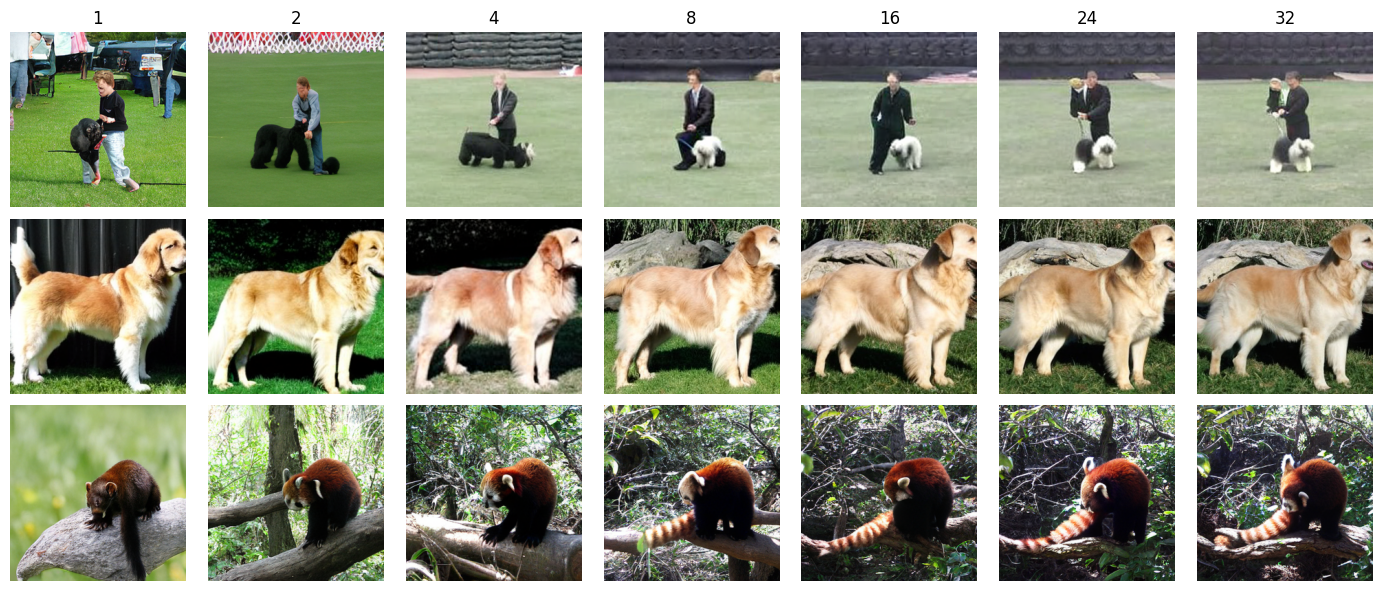

In [11]:
nums = [1, 2, 4, 8, 16, 24, 32]
with torch.autocast(device, dtype=dtype):
    viz_diff_slots(ae_model, slots_gen, nums, cfg=3.0)